In [3]:
%matplotlib inline
import os, glob
import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def my_det(matrix):
    '''
    Parameters
    ----------
    X : array_like

    Returns
    -------
    det : float
        Determinant of `a`.
    '''

    n = len(matrix)
    det = 1

    # Проверка того, что введенная матрица квадратная
    for s in range(len(matrix)):
      if len(matrix) != len(matrix[s]):
        raise ValueError("Матрица не является квадратной")

    for i in range(n):
        if matrix[i][i] == 0:
            # Если элемент на главной диагонали равен нулю, меняем строки местами
            for j in range(i+1, n):
                if matrix[j][i] != 0:
                    matrix[i], matrix[j] = matrix[j], matrix[i]
                    # Меняем знак определителя
                    det = det * (-1)
                    break
            else:
                # Если все элементы в столбце равны нулю, определитель равен нулю
                return 0

        for j in range(i+1, n):
            ratio = matrix[j][i] / matrix[i][i]
            for k in range(i, n):
                matrix[j][k] -= ratio * matrix[i][k]

    for i in range(n):
        det = det * matrix[i][i]

    return det


In [5]:
X = np.array([[0,0,1], [0,1,0], [1,0,0]])
print(X)
print(my_det(X))

[[0 0 1]
 [0 1 0]
 [1 0 0]]
0


## Первичное ознакомление

### Посмотрим, что мы вообще такое скачали :)

In [4]:
os.listdir('../data/')

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']

In [5]:
data_path = '../data/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'
df_meta = pd.read_csv(data_path + 'Meta.csv')
df_train = pd.read_csv(data_path + 'Train.csv')
df_test = pd.read_csv(data_path + 'Test.csv')

In [6]:
df_meta.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


Всего у нас 4 колонки в файле с метаданными. Путь до изображения $Path$, Класс знака $ClassId$, Форма знака $ShapeId$, и id знака $SignId$

In [7]:
print(f"Возможные значения параметра Класс: {df_meta.ClassId.min()} -- {df_meta.ClassId.max()}, всего {df_meta.ClassId.count()} класса")

Возможные значения параметра Класс: 0 -- 42, всего 43 класса


## Посмотрим на метаданные и эталонные знаки.

### Посмотрим более внимательно на то, какие классы знаков представлены в датасете. Соберем их в словарь и затем попробуем визуализировать эталонные изображения знаков из директории Meta с названием соответствующих классов под ними.

In [10]:
num_of_classes = len(df_meta.ClassId.unique())
class_dict = {}
class_labels = list(range(num_of_classes))
# Speed Class 0-9
speed_class = ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['20', '30', '50', '60', '70', '80']]]\
            + ['End of Speed Limit 80 kmph']
speed_class+= ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['100', '120']]]
speed_class
# 10, 11 No Passing
no_pass = ['No Passing' + item for item in ['', ' vehicle over 3.5 ton']]
# 12-43
rest = ['Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited',\
            'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road',
            'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing',
            'Bicycles crossing', 'Beware of ice/snow','Wild animals crossing', 'End speed + passing limits', 'Turn right ahead',
            'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left',
            'Roundabout mandatory', 'End of no passing', 'End no passing vehicle > 3.5 tons']
class_values = speed_class + no_pass + rest
class_dict = {keys:values for keys,values in zip(class_labels, class_values)}

In [11]:
class_dict

{0: 'Speed Limit 20 kmph',
 1: 'Speed Limit 30 kmph',
 2: 'Speed Limit 50 kmph',
 3: 'Speed Limit 60 kmph',
 4: 'Speed Limit 70 kmph',
 5: 'Speed Limit 80 kmph',
 6: 'End of Speed Limit 80 kmph',
 7: 'Speed Limit 100 kmph',
 8: 'Speed Limit 120 kmph',
 9: 'No Passing',
 10: 'No Passing vehicle over 3.5 ton',
 11: 'Right-of-way at intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Veh > 3.5 tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve left',
 20: 'Dangerous curve right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End speed + passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right',
 39:

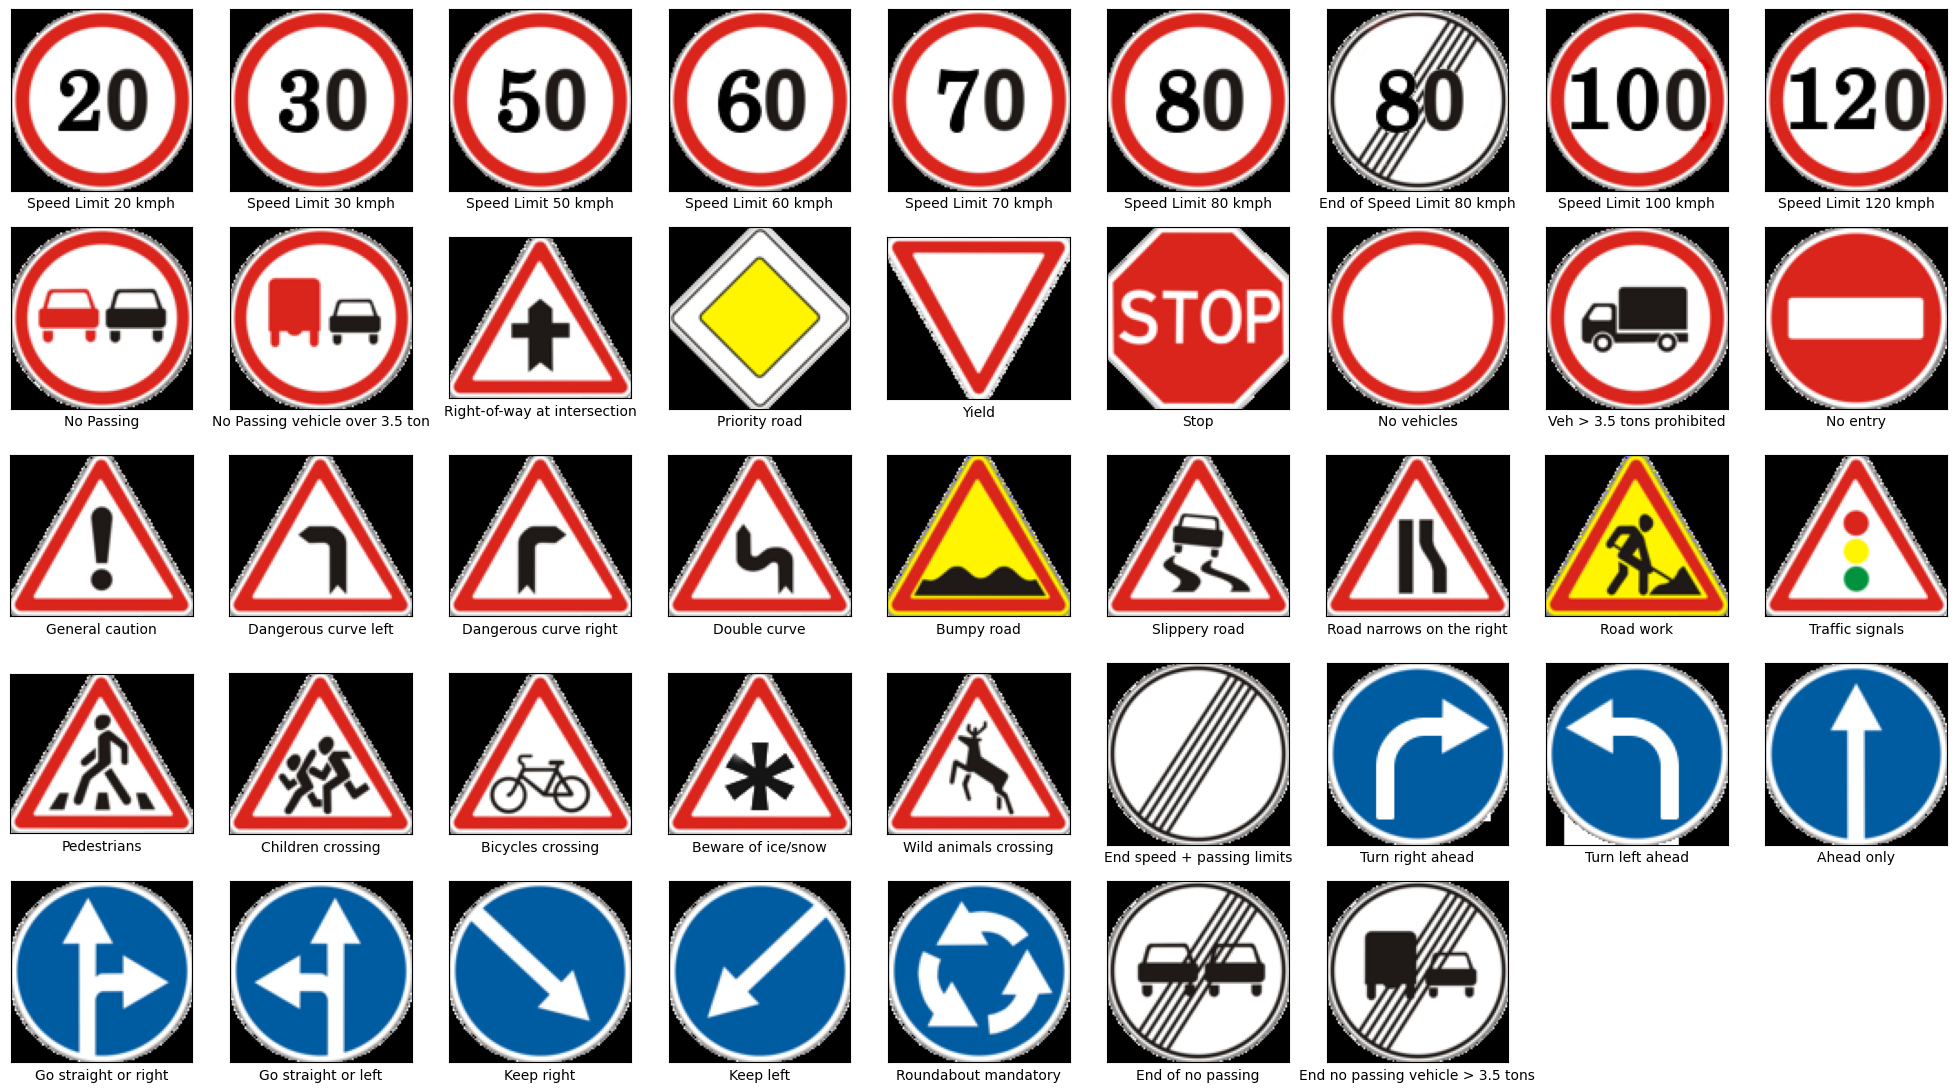

In [12]:
sortFunction = lambda x: int(os.path.basename(x)[:-4])
plt.figure(figsize = (25, 25))
for i, imagename in enumerate(sorted(glob.glob(data_path + 'Meta/' + '*.*'), key = sortFunction)):
    plt.subplot(9, 9, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_dict[i])
    image = cv2.imread(imagename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Теперь посмотрим на возможные формы знаков из колонки $ShapeId$

In [13]:
shape_dict = {0: 'Triangle', 1: 'Circle', 2: 'Diamond', 3: 'Hexagon', 4: 'Inverse Triangle'}
df_meta.ShapeId.value_counts()

ShapeId
1    25
0    15
2     1
4     1
3     1
Name: count, dtype: int64

In [14]:
def visualize_shape(shape = 1, count = 1):
    """
    Визуализирует count случайных знаков определенной формы из shape_dict
    """
    filenames = df_meta[df_meta.ShapeId==shape].sample(count).Path
    plt.figure(figsize = (20, 20))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

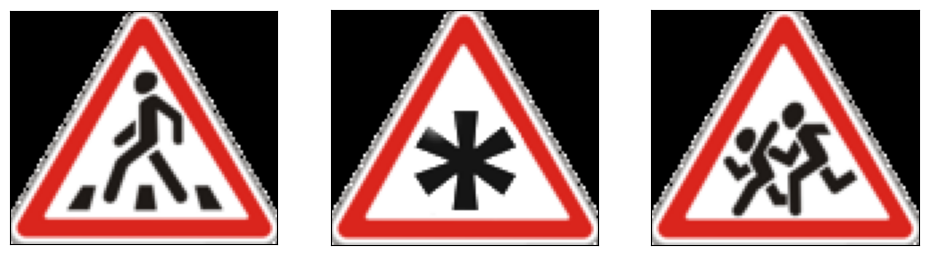

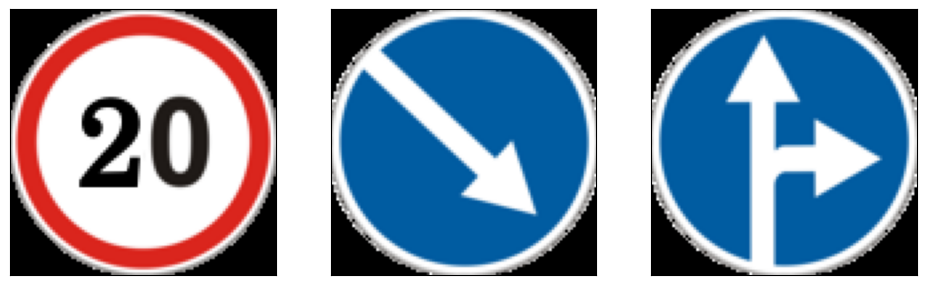

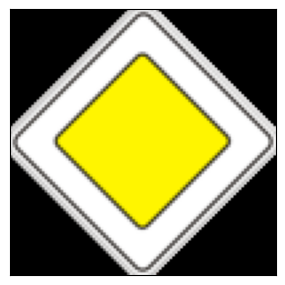

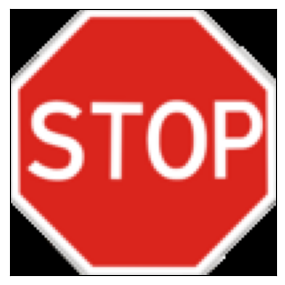

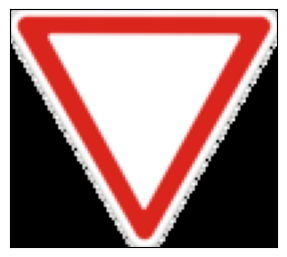

In [15]:
visualize_shape(0,3)
visualize_shape(1,3)
visualize_shape(2)
visualize_shape(3)
visualize_shape(4)

### Посмотрим на возможные цвета знаков

In [16]:
color_dict = {0:'Red', 1:'Blue', 2:'Yellow', 3:'White'}
df_meta.ColorId.value_counts()

ColorId
0    30
1     8
3     4
2     1
Name: count, dtype: int64

In [17]:
def visualize_color(color = 0, count = 1):
    """
    Визуализирует count случайных знаков определенного цвета color_dict
    """
    filenames = df_meta[df_meta.ColorId==color].sample(count).Path
    plt.figure(figsize = (20, 20))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(5, 5, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

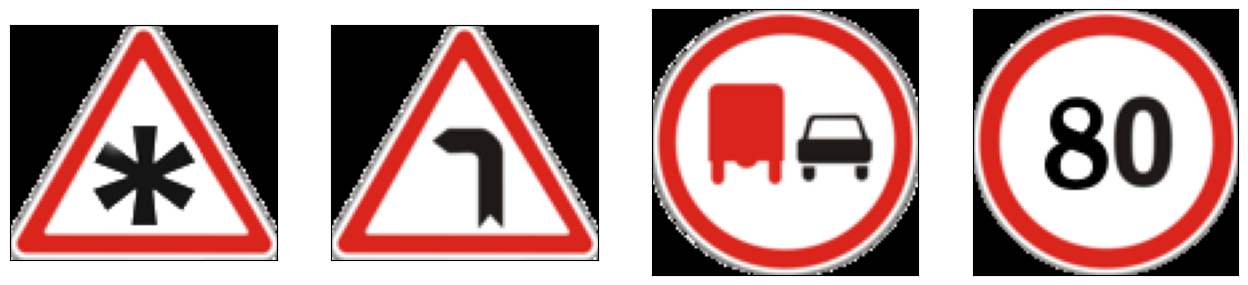

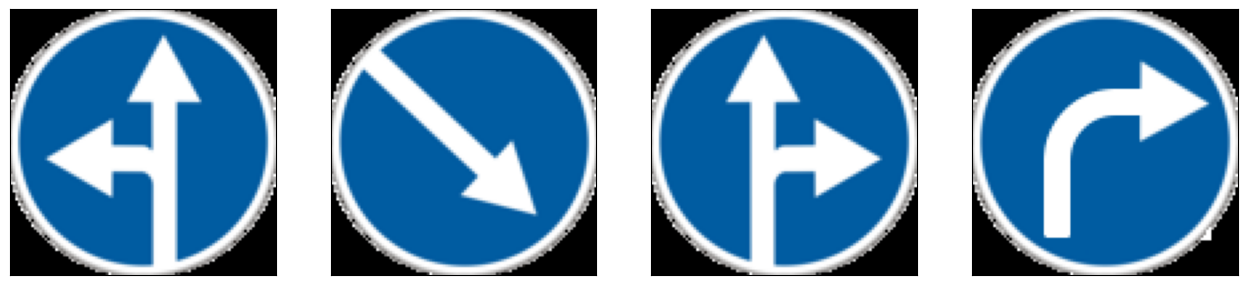

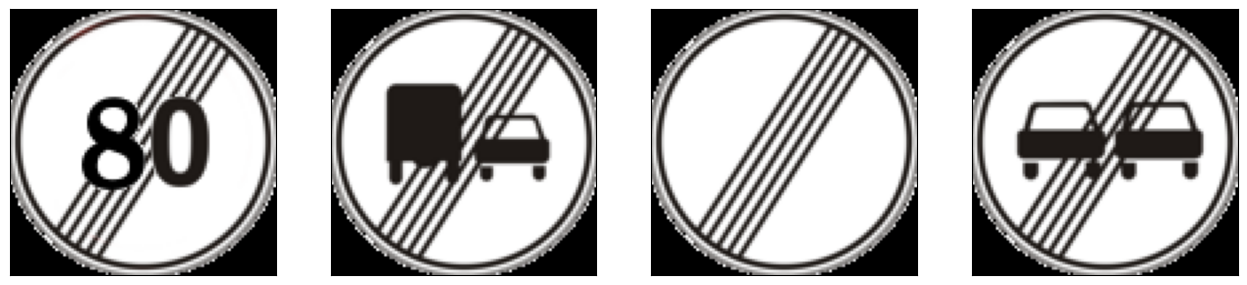

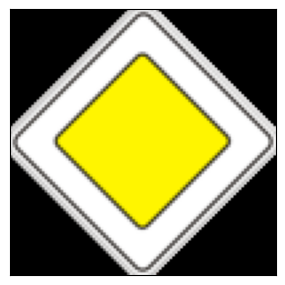

In [18]:
visualize_color(0,4)
visualize_color(1,4)
visualize_color(3,4)
visualize_color(2)

## Посмотрим на тренировочный датафрейм.

In [19]:
# Посмотрим на размер датафрейма
df_train.shape

(39209, 8)

In [20]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [21]:
df_train.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [22]:
df_train.ClassId.value_counts()

ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
6      420
34     420
22     390
36     390
40     360
20     360
21     330
39     300
29     270
24     270
32     240
27     240
41     240
42     240
37     210
0      210
19     210
Name: count, dtype: int64

In [23]:
# Создадим словарь train_dict, где ключами будут признаки, а значениями количество значений
train_dict = {}
train_dict = {keys:values for keys,values in zip(df_train.ClassId.value_counts().index, df_train.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Распределение классов в тренировочном датасете')

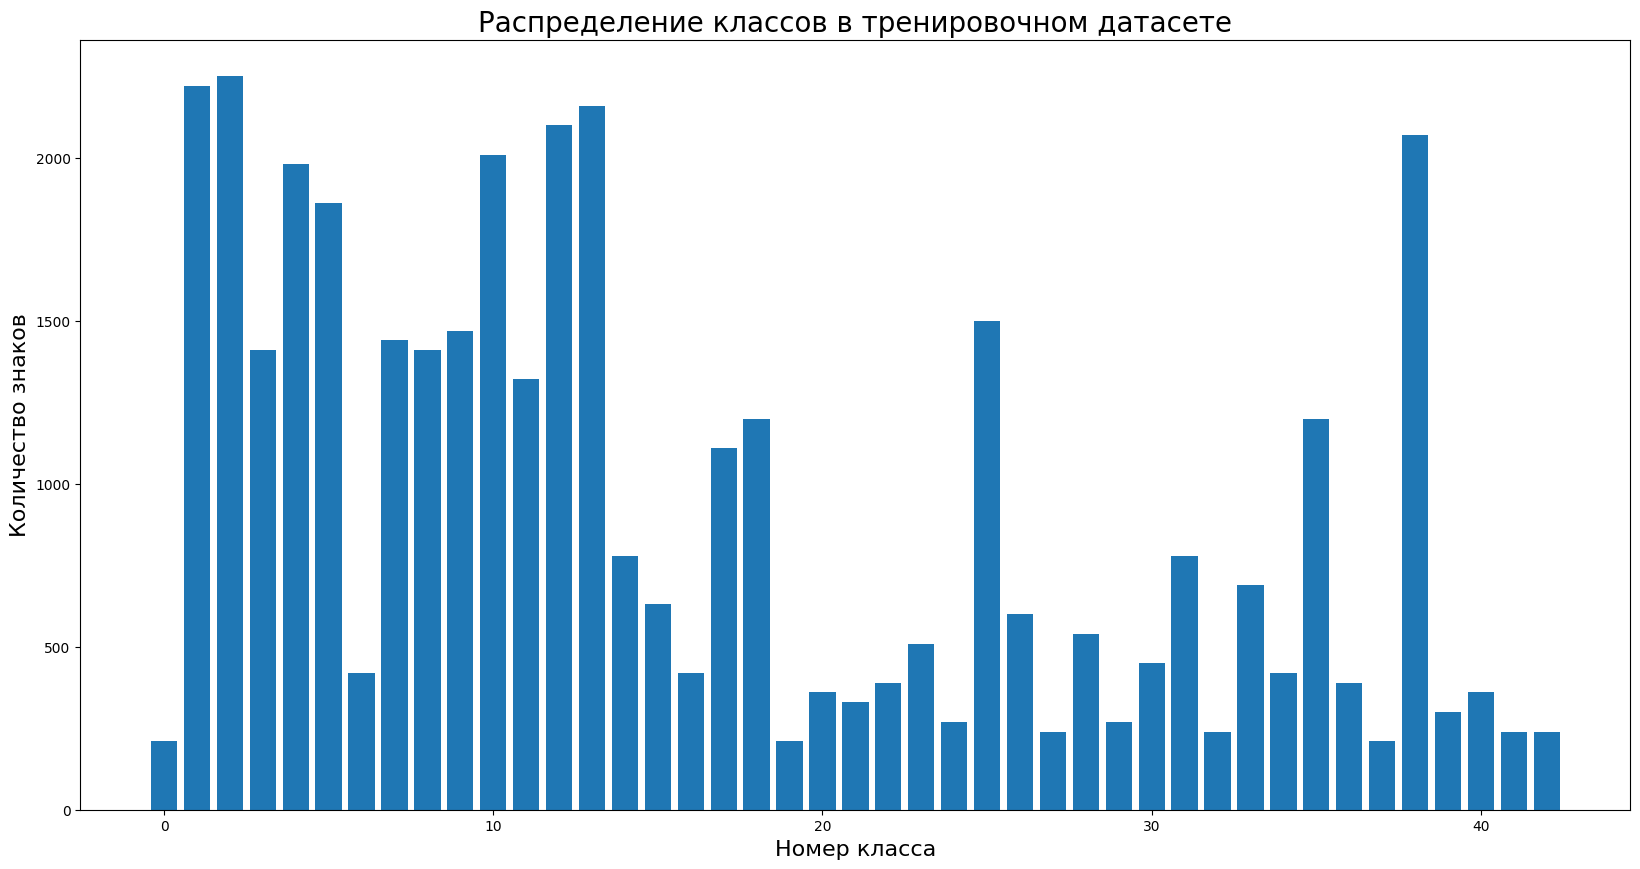

In [24]:
# Построим график распределения классов в тренировочном датасете
plt.figure(figsize = (20, 10))
plt.bar(train_dict.keys(), train_dict.values())
plt.xlabel('Номер класса', fontsize = 16)
plt.ylabel('Количество знаков',fontsize = 16)
plt.title('Распределение классов в тренировочном датасете', fontsize=20)

## Посмотрим на датафрейм для тестов.

In [25]:
df_test.shape

(12630, 8)

In [26]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [27]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [28]:
df_test.ClassId.value_counts()

ClassId
2     750
1     720
13    720
38    690
12    690
4     660
10    660
5     630
9     480
25    480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
31    270
14    270
15    210
33    210
26    180
30    150
16    150
28    150
6     150
23    150
22    120
36    120
34    120
24     90
29     90
20     90
40     90
21     90
39     90
42     90
32     60
27     60
41     60
19     60
0      60
37     60
Name: count, dtype: int64

In [29]:
# Создадим словарь train_dict, где ключами будут признаки, а значениями количество значений
test_dict = {}
test_dict = {keys:values for keys,values in zip(df_test.ClassId.value_counts().index, df_test.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Распределение классов в датасете для тестов')

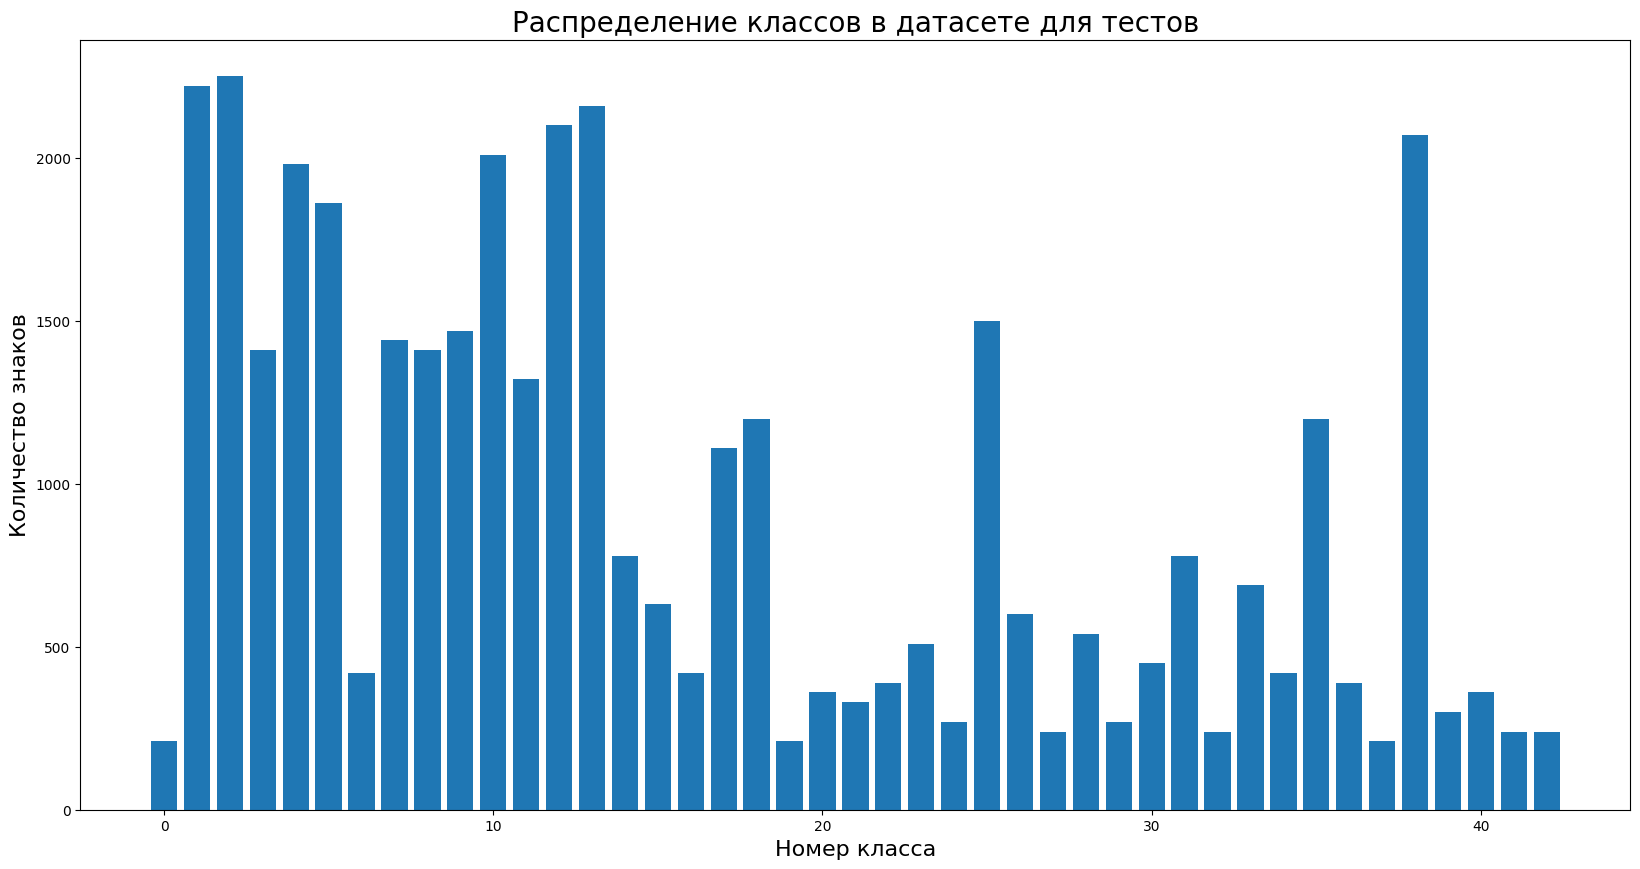

In [30]:
# Построим график распределения классов в тренировочном датасете
plt.figure(figsize = (20, 10))
plt.bar(train_dict.keys(), train_dict.values())
plt.xlabel('Номер класса', fontsize = 16)
plt.ylabel('Количество знаков',fontsize = 16)
plt.title('Распределение классов в датасете для тестов', fontsize=20)

## Проверка на баланс представления классов в данных.

Если посмотреть на распределение отдельных классов из датасетов для обучения и тестирования, набор данных может показаться несбалансированным. 
Поэтому было бы неплохо сразу проверить проверить насколько датасеты сбалансированы. Вероятно, это будет очень важно при обучении модели, потому что когда мы разделяем данные для обучения на обучение и проверку, мы хотели бы сохранить соотношение обоих наборов для каждого класса знака. Поэтому нам нужно, чтобы каждый класс был представлен в обоих выборках, и в достаточном количестве. 

In [31]:
df_balance = pd.DataFrame()
df_balance['labels'] = list(range(43))
df_balance['train'] = train_dict.values()
df_balance['test'] = test_dict.values()
df_balance['total'] = df_balance['train'] + df_balance['test']
df_balance['train_ratio'] = df_balance['train']/df_balance['total']
df_balance['test_ratio'] = df_balance['test']/df_balance['total']

Text(0.5, 1.0, 'Отношение представления классов в датасетах')

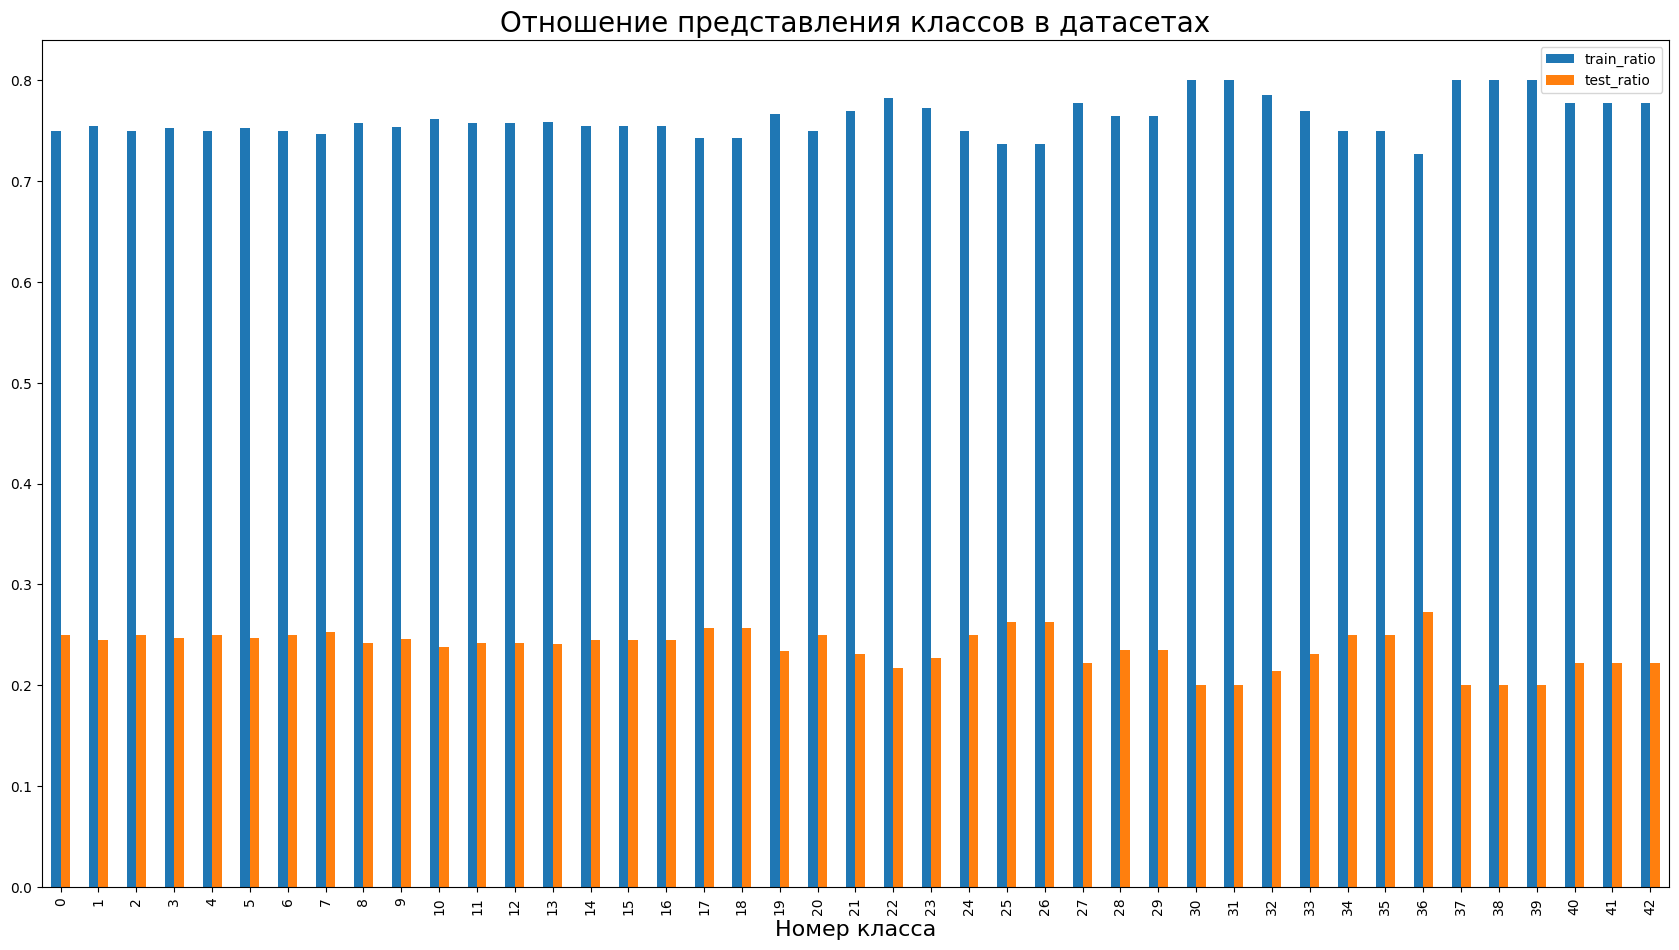

In [32]:
df_balance.plot(x = 'labels', y = ['train_ratio', 'test_ratio'], kind = 'bar', figsize = (21, 11))
plt.xlabel('Номер класса', fontsize = 16)
plt.title("Отношение представления классов в датасетах",fontsize=20)

Судя по графику выше, распределение классов в обоих выборках довольно равномерное, так что по идее никакой дополнительной обработки не потребуется.

## Проверка дубликатов в данных

In [33]:
df_train.Path.duplicated().unique()

array([False])

In [34]:
df_test.Path.duplicated().unique()

array([False])

Дубликатов не обнаружено